这个文件是针对MCNP所模拟的Eu-152模拟能谱验证gamut的分析功能。

我们希望实现以下工作：

1.导入开箱即用的预定义γ谱分析管道网；
2.导入不同NPS下的模拟能谱，并且可视化他的几个主要的峰；
3.使用管道网对模拟能谱进行分析，以计数率最高的能谱作为基准，分析低计数率下的峰面积计算不准确性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import gamspec

然后，我们希望导入预定义的管道网（分析流程）。

In [2]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
# peakfilter = gamspec.PeakSearcher()
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 1)

# 重新寻峰
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._min_height_ratio = 0.6
fsearch = gamspec.Flow(searcher, 2, 0, 5, 0)

# 分支合并
comb2 = gamspec.Combinor(2, func=combine)
fcomb2 = gamspec.Flow(comb2, 5, [0, 1], 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, fsearch, fcomb2, ffit])
pipenet.plot()

In [3]:
import pathlib
import pandas as pd
from re import match

folder = pathlib.Path(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析')
files = folder.glob('*.out')

combined_results = []
for file in files:
    output = folder / (file.stem +'.xlsx')
    if output.exists():
        df = pd.read_excel(str(output))
    else:
        spectrum = gamspec.Spectrum.from_MCNP(str(file))
        pipenet([spectrum])
        spec = pipenet.get_node(4)[0]
        spec.export_to_xml(folder / (file.stem +'.xml'))
        df = spec.export_to_pandas()
        df.to_excel(str(output))

    df['NPS'] = int(match(r'Eu152_benchmark_(\d+)', file.stem).group(1))
    combined_results.append(df)

In [4]:
spec = gamspec.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_60000.out')
pipenet([spec])

GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> SavitzkySmoother[O3W7]>>SecondConvolutionSearcher[F10] >> Node 1|[0]
|Execute: Node 0|[0] >> TIWaveletSmoother[O3MqTv] >> Node 1|[1]
|Execute: Node 1|[0, 1] >> Combinor >> Node 2|[0]
|Execute: Node 2|[0] >> AdaptiveSNIPStripper >> Node 5|[1]
|Execute: Node 2|[0] >> CovarianceSearcher[F4] >> Node 5|[0]
|Execute: Node 5|[0, 1] >> Combinor >> Node 3|[0]
|Execute: Node 3|[0] >> RegionPeakFitter >> Node 4|[0]
Fitting Region: 77~141, NPeaks=4, time=Fri Jan 26 13:15:56 2024
Finish Fitting Region: time=Fri Jan 26 13:16:08 2024
Fitting Region: 150~158, NPeaks=1, time=Fri Jan 26 13:16:08 2024
Finish Fitting Region: time=Fri Jan 26 13:16:09 2024
Fitting Region: 394~404, NPeaks=1, time=Fri Jan 26 13:16:09 2024


e:\Gamut_dev\gamspec\operators\AreaCalculator.py:213: RuntimeWarning: invalid value encountered in matmul
  fcounts[:] = shapes @ heights


LinAlgError: partial_matrix.T @ partial_matrix is not invertible.
Use pseudo-inverse instead
Finish Fitting Region: time=Fri Jan 26 13:16:09 2024
Fitting Region: 406~419, NPeaks=2, time=Fri Jan 26 13:16:09 2024
LinAlgError: partial_matrix.T @ partial_matrix is not invertible.
Use pseudo-inverse instead
Finish Fitting Region: time=Fri Jan 26 13:16:11 2024
Fitting Region: 826~845, NPeaks=1, time=Fri Jan 26 13:16:11 2024
Finish Fitting Region: time=Fri Jan 26 13:16:12 2024
Fitting Region: 1166~1184, NPeaks=2, time=Fri Jan 26 13:16:12 2024
Finish Fitting Region: time=Fri Jan 26 13:16:18 2024
Fitting Region: 1243~1265, NPeaks=1, time=Fri Jan 26 13:16:18 2024
Finish Fitting Region: time=Fri Jan 26 13:16:19 2024
Fitting Region: 1388~1416, NPeaks=1, time=Fri Jan 26 13:16:19 2024
Finish Fitting Region: time=Fri Jan 26 13:16:20 2024
Fitting Region: 1507~1522, NPeaks=1, time=Fri Jan 26 13:16:20 2024
Finish Fitting Region: time=Fri Jan 26 13:16:20 2024
Fitting Region: 2339~2360, NPeaks=1, time=Fri

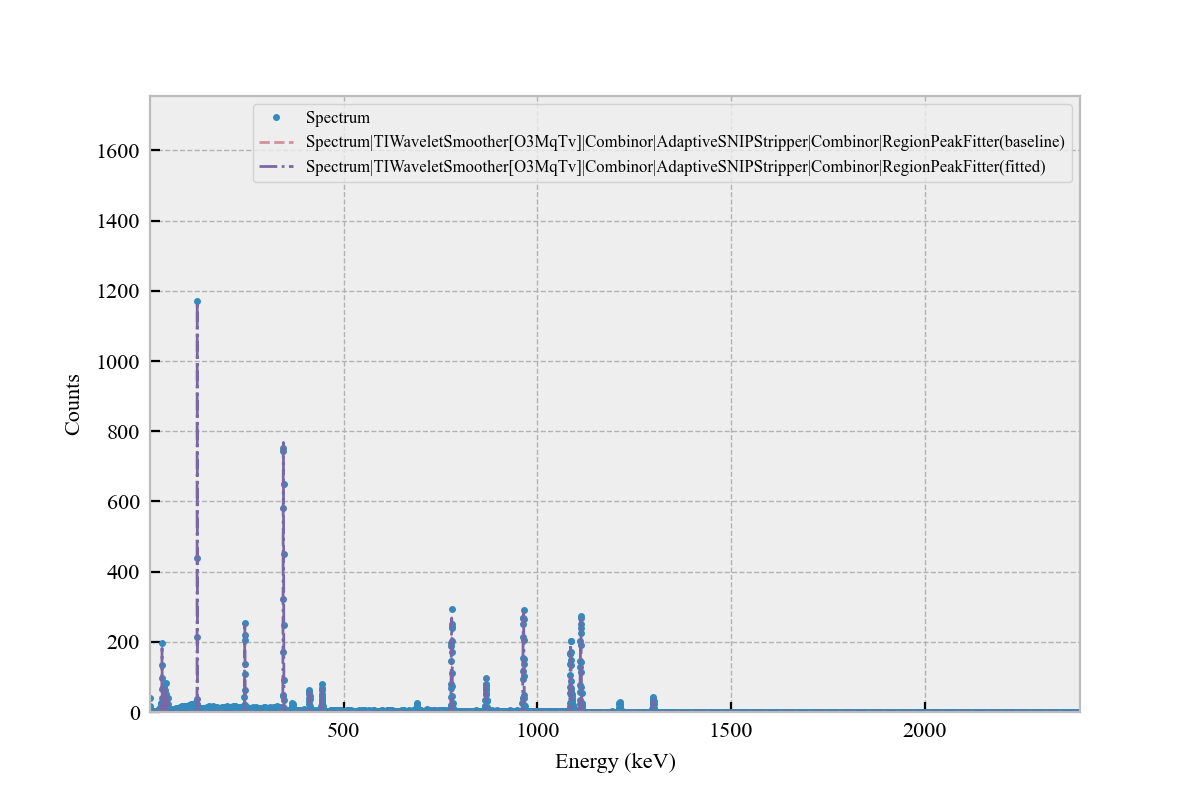

In [5]:
%matplotlib widget
plt.close()
spec.plot('.')
out = pipenet.get_node(4)[0].plot_peaks()
plt.legend(fontsize=6)
plt.show()

In [6]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12])
def energy_in_group(energy):
    return np.any(np.abs(energy-energies)<2)
energy_in_group(50)

False

In [7]:
files = folder.glob('*.out')
for file in files:
    print(str(file))
    spec = gamspec.Spectrum.from_MCNP(str(file))
    print(len(spec))

E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_100000.out
8192
E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_1000000.out
8192
E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_10000000.out
8192
E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_100000000.out
8192
E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_60000.out
8192
E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_80000.out
8192


In [8]:
results = pd.concat(combined_results)
select_results = results.groupby('NPS')
new_select_results = []
for group_key in select_results.groups.keys():
    df = select_results.get_group(group_key)
    df['interested'] = df['energy'].apply(energy_in_group)
    print(df)
    df = df[df['interested']==True]
    new_select_results.append(df)
new_select_results = pd.concat(new_select_results)
new_select_results.to_excel('results_simulated_Eu152_selected.xlsx')

C:\Users\alber\AppData\Local\Temp\ipykernel_37864\1330158012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interested'] = df['energy'].apply(energy_in_group)
C:\Users\alber\AppData\Local\Temp\ipykernel_37864\1330158012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interested'] = df['energy'].apply(energy_in_group)
C:\Users\alber\AppData\Local\Temp\ipykernel_37864\1330158012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

    Unnamed: 0  left  right       energy  location       height    stderr  \
0            0    92    110    31.076748       106   183.033827  1.040808   
1            1   130    141    40.165224       137    74.413748  1.413720   
2            2   152    160    45.442404       155    43.273988  0.596976   
3            3   406    424   121.961510       416  1194.079549  0.607597   
4            4   826    845   244.802526       835   247.101026  1.624186   
5            5  1166   1182   344.482587      1175   779.497233  2.110329   
6            6  1244   1266   367.936719      1255    21.031842  2.075712   
7            7  1388   1416   411.326864      1403    56.924511  2.779542   
8            8  1507   1522   444.162648      1515    67.625620  2.795825   
9            9  2339   2360   688.965151      2350    21.087217  2.940642   
10          10  2640   2672   778.970383      2657   268.079430  3.639817   
11          11  2949   2970   867.509731      2959    84.199082  3.704763   

PermissionError: [Errno 13] Permission denied: 'results_simulated_Eu152_selected.xlsx'

In [ ]:
# select_results = []
# for i, row in results.iterrows():
#     if energy_in_group(row['energy'], energies):
#         select_results.append(row)
# select_results = pd.DataFrame(select_results).groupby('energy')

# for df in select_results:
#     print(df)